--- STEP 1: UPLOAD DATA ---
Please upload your 'Final.csv' file when the button appears below.


Saving Final.csv to Final (1).csv

Processing file: Final (1).csv...
Data loaded successfully.
Total rows: 43732

--- STEP 3: SEPARATING DATA MODES ---
Heating Data Points (Feel < 65.0°F): 26052
Cooling Data Points (Feel >= 65.0°F): 17680

--- HEATING SENSITIVITY SUMMARY (Winter/Cold) ---
Interpretation: A more NEGATIVE slope means heating demand is MORE sensitive to cold.
|   Year |   Slope (MW/°F) |   Correlation |
|-------:|----------------:|--------------:|
|   2020 |         -29.504 |        -0.631 |
|   2021 |         -33.06  |        -0.731 |
|   2022 |         -36.485 |        -0.797 |
|   2023 |         -29.517 |        -0.672 |
|   2024 |         -33.817 |        -0.729 |
|   2025 |         -42.179 |        -0.845 |

--- COOLING SENSITIVITY SUMMARY (Summer/Hot) ---
Interpretation: A more POSITIVE slope means cooling demand is MORE sensitive to heat.
|   Year |   Slope (MW/°F) |   Correlation |
|-------:|----------------:|--------------:|
|   2020 |           4.469 |         0

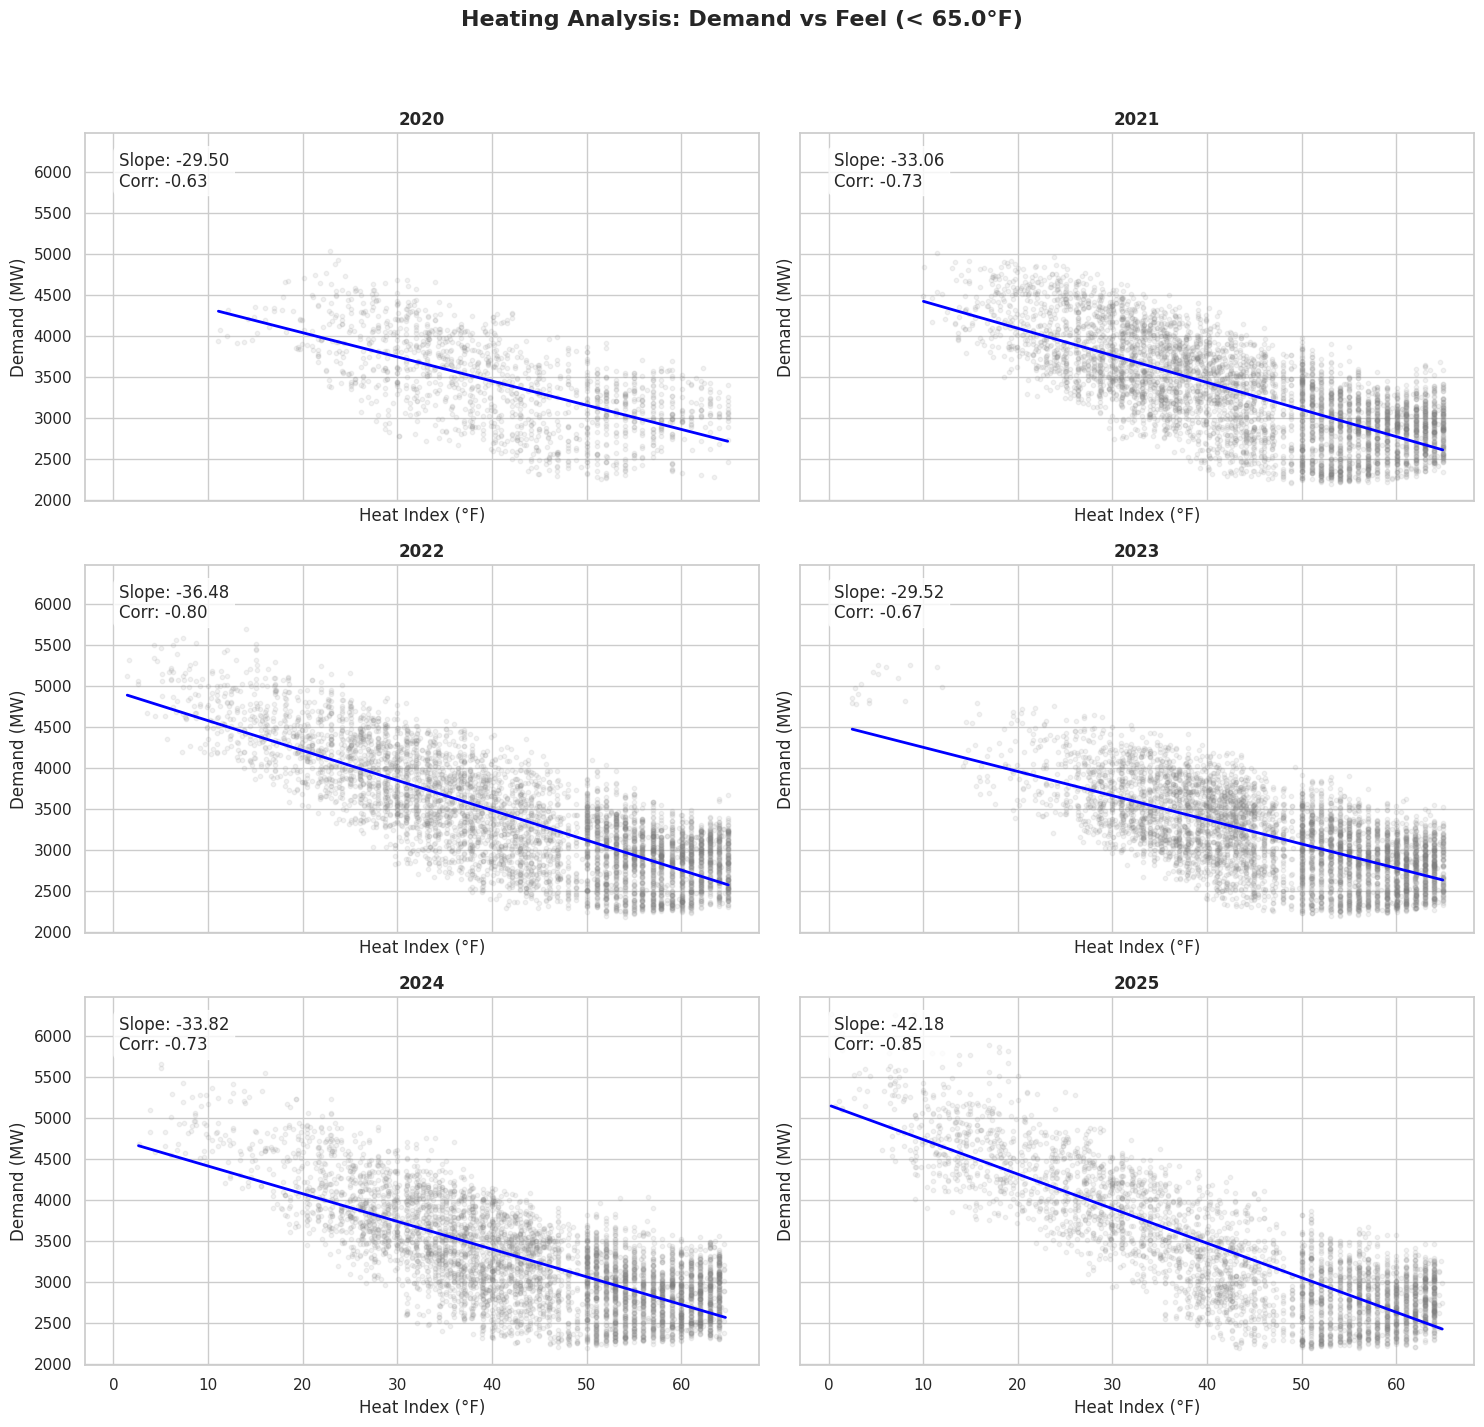


Generating Cooling Scatter Plots (Threshold >= 65.0°F)...


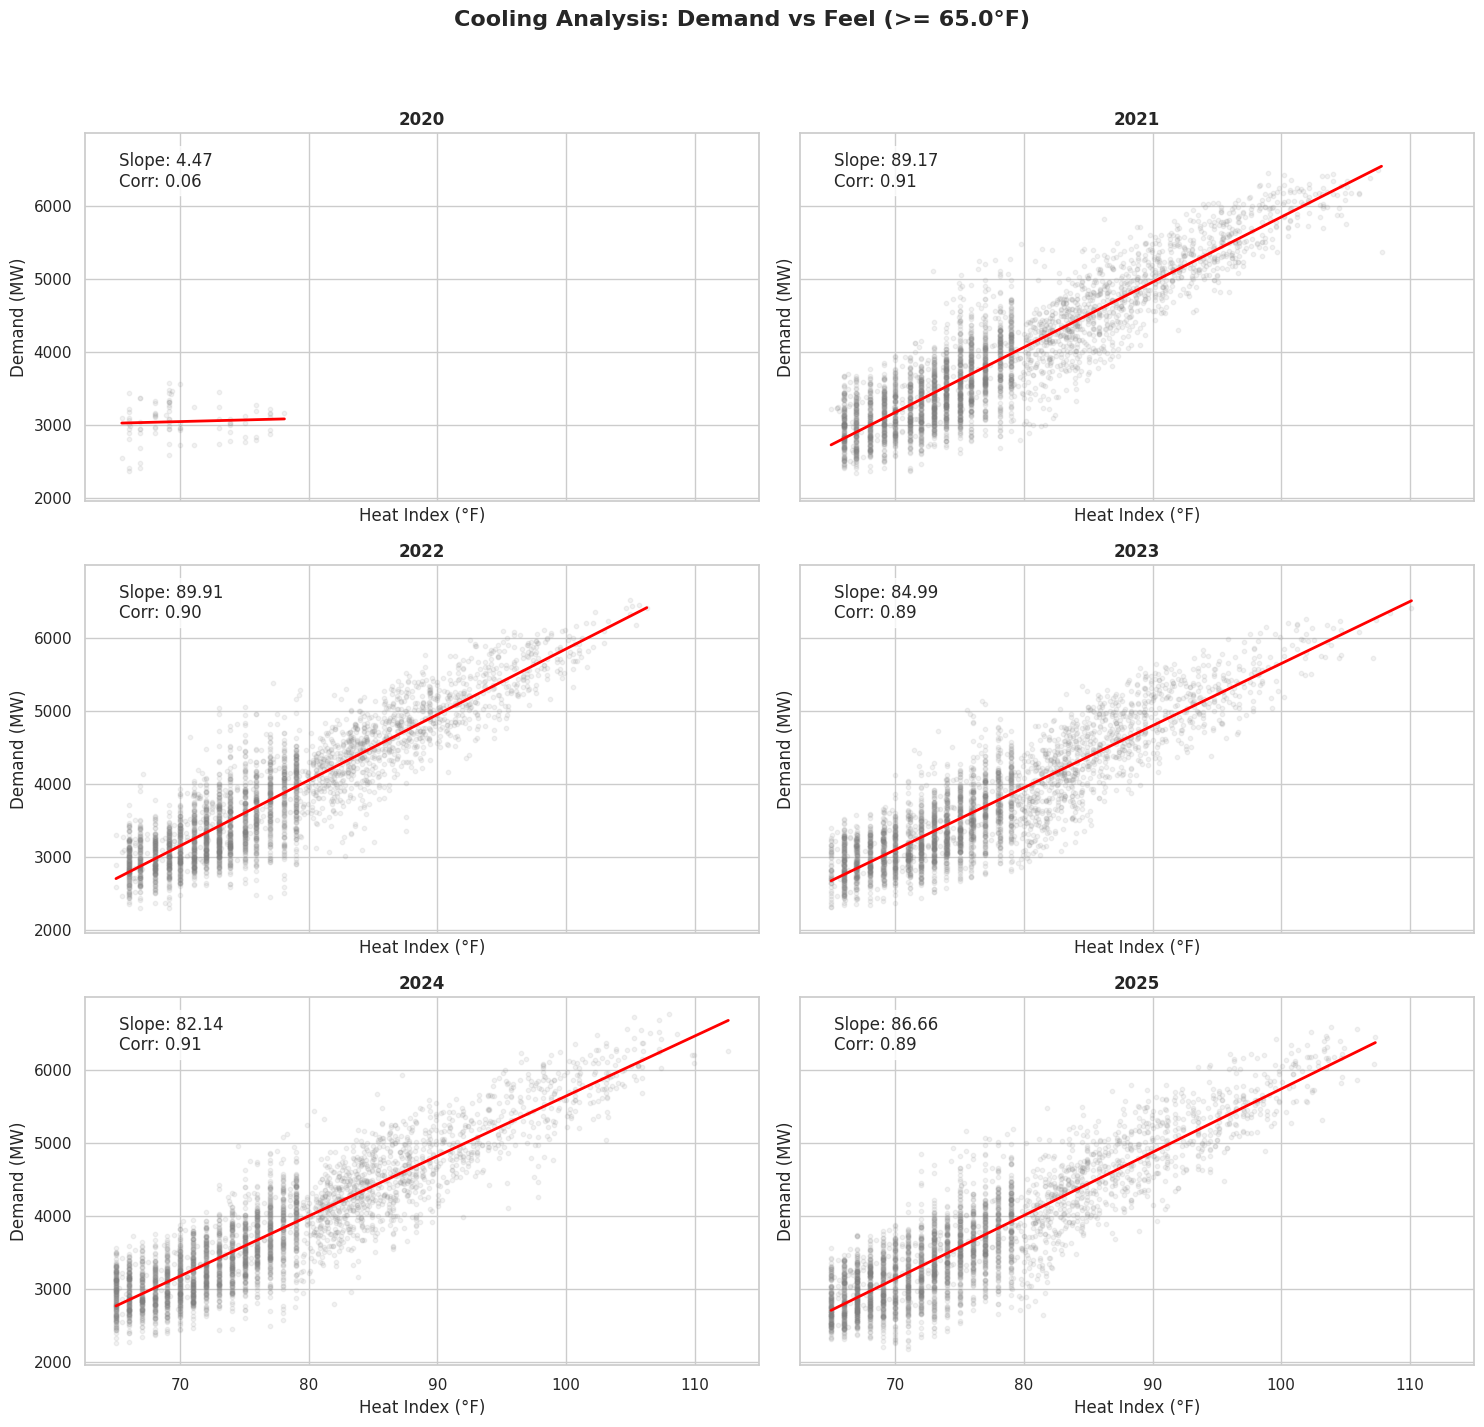


Generating Sensitivity Trend Comparison...


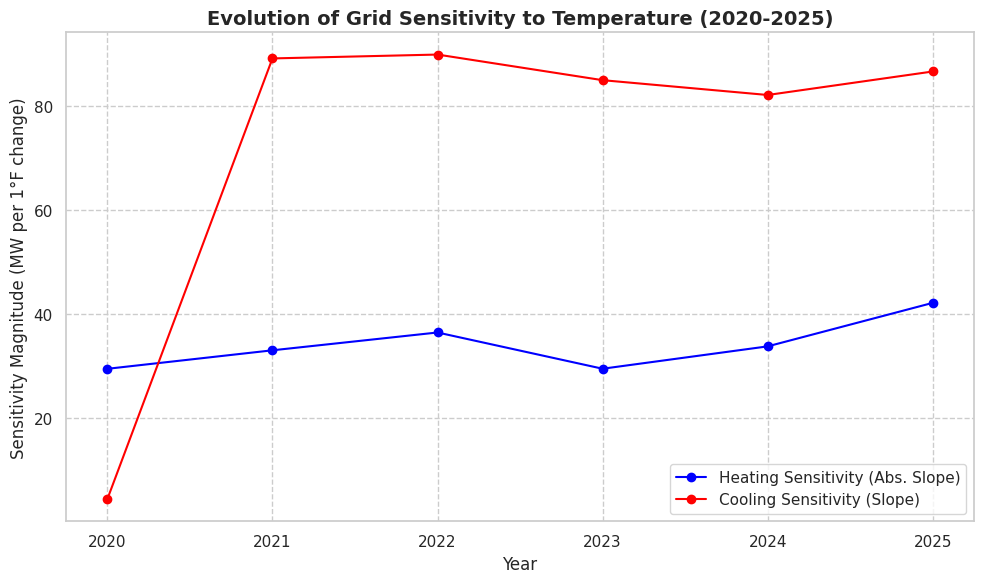


--- FINAL ANALYSIS ---
1. The Blue line tracks how strongly the grid reacts to COLD (Heating).
2. The Red line tracks how strongly the grid reacts to HEAT (Cooling).
3. If the Red line is trending UP, the grid is becoming MORE sensitive to summer heat (Climate Change indicator).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import io
from google.colab import files

SPLIT_THRESHOLD_F = 65.0

def main():
    print("--- STEP 1: UPLOAD DATA ---")
    print("Please upload your 'Final.csv' file when the button appears below.")
    uploaded = files.upload()

    filename = next(iter(uploaded))
    print(f"\nProcessing file: {filename}...")

    try:
        df = pd.read_csv(io.BytesIO(uploaded[filename]))

        df['Time_UTC'] = pd.to_datetime(df['Time_UTC'])
        df = df.set_index('Time_UTC').sort_index()

        cols_to_check = ['mw', 'feel']
        for col in cols_to_check:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        df.dropna(subset=['mw', 'feel'], inplace=True)

        df['Year'] = df.index.year

        print("Data loaded successfully.")
        print(f"Total rows: {len(df)}")

    except Exception as e:
        print(f"Error loading data: {e}")
        return

    print("\n--- STEP 3: SEPARATING DATA MODES ---")

    df_heating = df[df['feel'] < SPLIT_THRESHOLD_F].copy()

    df_cooling = df[df['feel'] >= SPLIT_THRESHOLD_F].copy()

    print(f"Heating Data Points (Feel < {SPLIT_THRESHOLD_F}°F): {len(df_heating)}")
    print(f"Cooling Data Points (Feel >= {SPLIT_THRESHOLD_F}°F): {len(df_cooling)}")

    def analyze_sensitivity(sub_df, mode_name):
        results = []
        valid_years = sorted(sub_df['Year'].unique())

        for year in valid_years:
            df_year = sub_df[sub_df['Year'] == year]

            if len(df_year) < 50:
                continue

            corr, _ = pearsonr(df_year['feel'], df_year['mw'])

            slope, intercept = np.polyfit(df_year['feel'], df_year['mw'], 1)

            results.append({
                'Year': year,
                'Mode': mode_name,
                'Slope (MW/°F)': slope,
                'Correlation': corr,
                'Count': len(df_year)
            })
        return pd.DataFrame(results)

    heating_results = analyze_sensitivity(df_heating, "Heating")
    cooling_results = analyze_sensitivity(df_cooling, "Cooling")

    print("\n--- HEATING SENSITIVITY SUMMARY (Winter/Cold) ---")
    print("Interpretation: A more NEGATIVE slope means heating demand is MORE sensitive to cold.")
    print(heating_results[['Year', 'Slope (MW/°F)', 'Correlation']].round(3).to_markdown(index=False))

    print("\n--- COOLING SENSITIVITY SUMMARY (Summer/Hot) ---")
    print("Interpretation: A more POSITIVE slope means cooling demand is MORE sensitive to heat.")
    print(cooling_results[['Year', 'Slope (MW/°F)', 'Correlation']].round(3).to_markdown(index=False))

    sns.set_theme(style="whitegrid")

    def plot_mode_scatter(sub_df, results_df, mode_name, color):
        years = results_df['Year'].unique()
        cols = 2
        rows = int(np.ceil(len(years) / cols))

        fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows), sharex=True, sharey=True)
        axes = axes.flatten()

        fig.suptitle(f'{mode_name} Analysis: Demand vs Feel (< {SPLIT_THRESHOLD_F}°F)', fontsize=16, fontweight='bold') if mode_name == 'Heating' else fig.suptitle(f'{mode_name} Analysis: Demand vs Feel (>= {SPLIT_THRESHOLD_F}°F)', fontsize=16, fontweight='bold')

        for i, year in enumerate(years):
            ax = axes[i]
            data = sub_df[sub_df['Year'] == year]

            sns.regplot(
                x='feel', y='mw', data=data, ax=ax,
                scatter_kws={'alpha':0.1, 's':10, 'color': 'gray'},
                line_kws={'color': color, 'lw': 2},
                ci=None
            )

            res = results_df[results_df['Year'] == year].iloc[0]
            slope = res['Slope (MW/°F)']
            corr = res['Correlation']

            ax.set_title(f"{year}", fontsize=12, fontweight='bold')
            ax.text(0.05, 0.95, f"Slope: {slope:.2f}\nCorr: {corr:.2f}",
                    transform=ax.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

            ax.set_xlabel("Heat Index (°F)")
            ax.set_ylabel("Demand (MW)")

        for j in range(len(years), len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    print(f"\nGenerating Heating Scatter Plots (Threshold < {SPLIT_THRESHOLD_F}°F)...")
    plot_mode_scatter(df_heating, heating_results, "Heating", "blue")

    print(f"\nGenerating Cooling Scatter Plots (Threshold >= {SPLIT_THRESHOLD_F}°F)...")
    plot_mode_scatter(df_cooling, cooling_results, "Cooling", "red")

    print("\nGenerating Sensitivity Trend Comparison...")
    plt.figure(figsize=(10, 6))

    plt.plot(heating_results['Year'], heating_results['Slope (MW/°F)'].abs(),
             marker='o', color='blue', label='Heating Sensitivity (Abs. Slope)')

    plt.plot(cooling_results['Year'], cooling_results['Slope (MW/°F)'],
             marker='o', color='red', label='Cooling Sensitivity (Slope)')

    plt.title("Evolution of Grid Sensitivity to Temperature (2020-2025)", fontsize=14, fontweight='bold')
    plt.xlabel("Year")
    plt.ylabel("Sensitivity Magnitude (MW per 1°F change)")
    plt.grid(True, linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n--- FINAL ANALYSIS ---")
    print("1. The Blue line tracks how strongly the grid reacts to COLD (Heating).")
    print("2. The Red line tracks how strongly the grid reacts to HEAT (Cooling).")
    print("3. If the Red line is trending UP, the grid is becoming MORE sensitive to summer heat (Climate Change indicator).")

if __name__ == "__main__":
    main()